In [21]:
import chess
import numpy as np

def one_hot_encode_piece(piece):
    pieces = list('rnbqkpRNBQKP.')
    arr = np.zeros(len(pieces))
    piece_to_index = {p: i for i, p in enumerate(pieces)}
    index = piece_to_index[piece]
    arr[index] = 1
    return arr

def encode_board(board):
    # first lets turn the board into a string
    board_str = str(board)
    # then lets remove all the spaces
    board_str = board_str.replace(' ', '')
    board_list = []
    for row in board_str.split('\n'):
        row_list = []
        for piece in row:
            row_list.append(one_hot_encode_piece(piece))
        board_list.append(row_list)
    return np.array(board_list)

In [22]:
# We'll use pandas to pull in all our training data
import pandas as pd

train_df = pd.read_csv('dataset/train.csv', index_col='id')

train_df.head()

,board,black_score,best_move
id,,,
80091,6R1/8/5K2/8/5k2/8/8/2r5 w - - 89 118,0.0,g8d8
18578,r1bn1rk1/1p2b1p1/1q2p2p/p2p1p1n/P2P3P/2PB1N2/1...,-131.0,f3e5
11580,r2qkb1r/2p2pp1/p1n2nP1/1p1p3p/P7/1Q5b/1PP1PPB1...,-490.0,g6f7
72805,8/4kp2/R6p/8/4K3/8/8/8 b - - 7 85,-574.0,h6h5
74310,8/8/k7/4R3/8/6K1/8/1r6 w - - 99 90,0.0,e5e6


In [23]:
# In order to tell what phase of the game we're in,
# we can count the total "points of material" on the board.
# If there are lots of pieces left of the board,
# we're probably in the opening, and if we only have a few left,
# we're probably near the endgame.

def count_material(fen):
    total_material = 0
    material_dict = {
        'p': 1,
        'b': 3,
        'n': 3,
        'r': 5,
        'q': 9
    }
    for char in fen.lower():
        if char in material_dict:
            total_material += material_dict[char]
            
    return total_material

train_df['total_material'] = train_df['board'].apply(count_material)

(array([ 5973., 11022.,  8581.,  6077.,  4980.,  4993.,  4471.,  3682.,
         2834.,  6172.]),
 array([  1.,  11.,  21.,  31.,  41.,  51.,  61.,  71.,  81.,  91., 101.]),
 <BarContainer object of 10 artists>)

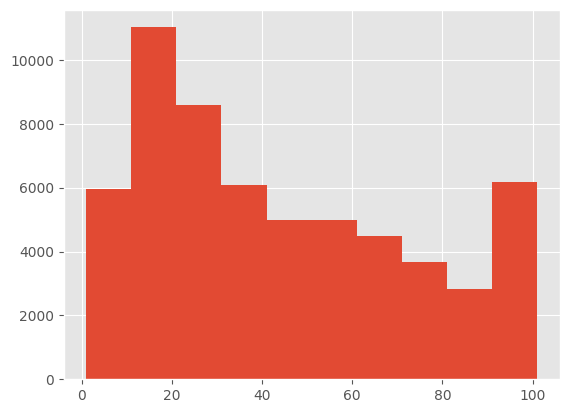

In [24]:
import matplotlib.pyplot as plt


# This histogram of all our boards total material is interesting!
# We have a lot of boards with relatively few points,
# and only a few with more than 70.
# We see an interesting spike around 100, which is
# probably due to promotion, when a pawn reaches the end of board 
# and can turn into a queen. Promotion usually happens near the end
# of a game, so our hueristic isn't perfect (sometimes having
# a lot of points of material left means you're in the endgame).
# But it should still work well enough!
# Let's say:
# Opening: > 60 points of material
# Midgame: between 30 and 60 points of material
# Endgame: less than 30 points of material
# The exact cutoff doesn't matter; the important
# part is that we're breaking our hard problem (all of chess)
# in to easier subproblems we can easily identify.
plt.hist(train_df['total_material'])

In [25]:
# Let's break our training data into each of our phases
endgame_df = train_df[train_df['total_material'] < 30]
midgame_df = train_df[(30 <= train_df['total_material']) & (train_df['total_material'] <= 60)]
opening_df = train_df[60 < train_df['total_material']]

In [26]:
import numpy as np
def encode_fen_string(fen_str):
    board = chess.Board(fen=fen_str)
    return encode_board(board)

In [27]:
# One function to rule them all

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# The function accepts a unique dataset,
# and then trains a model on it and returns that model
def generate_model(data_to_train_on):
    val_df = data_to_train_on[-1000:]
    train_df = data_to_train_on[:-1000]
    
    X_train = np.stack(train_df['board'].apply(encode_fen_string))
    y_train = train_df['black_score']

    X_val = np.stack(val_df['board'].apply(encode_fen_string))
    y_val = val_df['black_score']
    
    model = Sequential([
        Flatten(),
        Dense(1024, activation='relu'),
        Dense(1),
    ])
    
    model.compile(
        optimizer='rmsprop',
        loss='mean_squared_error')

    # To test things out, let's train for 20 epochs and see how our model is doing
    history = model.fit(
        X_train,
        y_train,
        epochs=40,
        validation_data=(X_val, y_val))

    import matplotlib.pyplot as plt

    # Lets plot the history of our training session to see how things progressed over time
    plt.style.use('ggplot')
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend()
    plt.title('Loss During Training')
    plt.show()
    
    return model

Epoch 1/40
755/755 [==============================] - 12s 15ms/step - loss: 160626.9844 - val_loss: 131168.1562
Epoch 2/40
755/755 [==============================] - 12s 16ms/step - loss: 129749.8438 - val_loss: 116486.6016
Epoch 3/40
755/755 [==============================] - 12s 16ms/step - loss: 119570.2266 - val_loss: 109203.4922
Epoch 4/40
755/755 [==============================] - 10s 13ms/step - loss: 114203.2500 - val_loss: 105501.4062
Epoch 5/40
755/755 [==============================] - 12s 15ms/step - loss: 111246.8672 - val_loss: 107447.8906
Epoch 6/40
755/755 [==============================] - 10s 14ms/step - loss: 108947.8359 - val_loss: 101153.0469
Epoch 7/40
755/755 [==============================] - 11s 15ms/step - loss: 107206.5391 - val_loss: 99967.8828
Epoch 8/40
755/755 [==============================] - 9s 12ms/step - loss: 105562.3047 - val_loss: 97640.0469
Epoch 9/40
755/755 [==============================] - 9s 12ms/step - loss: 104547.5078 - val_loss: 102277.2

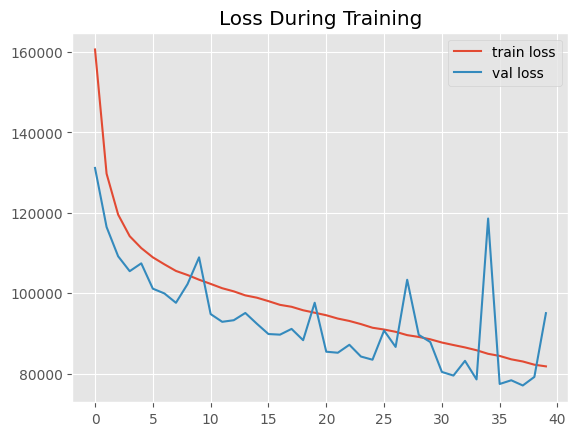

In [28]:
endgame_model = generate_model(endgame_df)

Epoch 1/40
485/485 [==============================] - 10s 18ms/step - loss: 158863.0312 - val_loss: 149156.6875
Epoch 2/40
485/485 [==============================] - 9s 18ms/step - loss: 142659.6719 - val_loss: 137940.8281
Epoch 3/40
485/485 [==============================] - 9s 18ms/step - loss: 130386.9922 - val_loss: 127426.2188
Epoch 4/40
485/485 [==============================] - 9s 18ms/step - loss: 120551.8594 - val_loss: 121654.4531
Epoch 5/40
485/485 [==============================] - 9s 18ms/step - loss: 112719.5156 - val_loss: 114707.2969
Epoch 6/40
485/485 [==============================] - 9s 19ms/step - loss: 107204.4531 - val_loss: 110853.4062
Epoch 7/40
485/485 [==============================] - 9s 19ms/step - loss: 102335.8047 - val_loss: 105862.3359
Epoch 8/40
485/485 [==============================] - 9s 19ms/step - loss: 99419.7031 - val_loss: 110104.2969
Epoch 9/40
485/485 [==============================] - 9s 18ms/step - loss: 96772.3750 - val_loss: 99629.3047
Epo

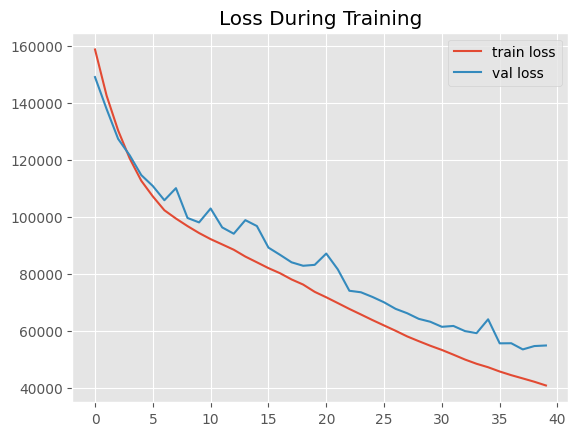

In [29]:
midgame_model = generate_model(midgame_df)

Epoch 1/40
505/505 [==============================] - 10s 19ms/step - loss: 118447.1250 - val_loss: 99238.3047
Epoch 2/40
505/505 [==============================] - 6s 13ms/step - loss: 103969.7734 - val_loss: 87503.0078
Epoch 3/40
505/505 [==============================] - 6s 12ms/step - loss: 92843.0156 - val_loss: 80055.7500
Epoch 4/40
505/505 [==============================] - 6s 13ms/step - loss: 84300.4375 - val_loss: 75602.7109
Epoch 5/40
505/505 [==============================] - 7s 14ms/step - loss: 77931.4375 - val_loss: 69453.1875
Epoch 6/40
505/505 [==============================] - 6s 12ms/step - loss: 73466.5391 - val_loss: 66433.7969
Epoch 7/40
505/505 [==============================] - 7s 13ms/step - loss: 70456.1875 - val_loss: 64845.8516
Epoch 8/40
505/505 [==============================] - 10s 21ms/step - loss: 67840.7891 - val_loss: 64432.2461
Epoch 9/40
505/505 [==============================] - 7s 14ms/step - loss: 65948.5625 - val_loss: 61768.8008
Epoch 10/40
505

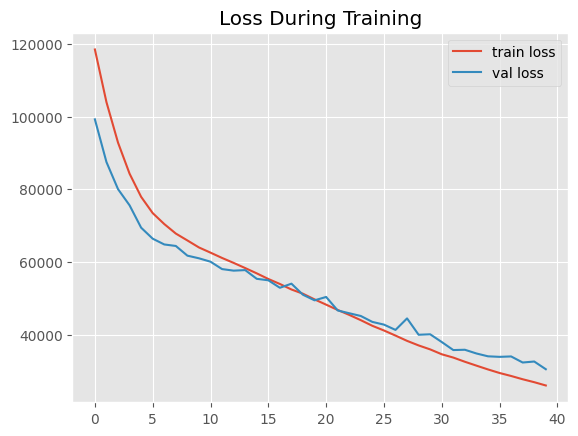

In [30]:
opening_model = generate_model(opening_df)

In [31]:
# Now we can update our play function to use the right model based on how many material
# are left
def play_nn(fen, show_move_evaluations=False):
    # We can create a python-chess board instance from the FEN string like this:
    board = chess.Board(fen=fen)

    material = count_material(fen)
    if material < 30:
        model = endgame_model
    elif material > 60:
        model = opening_model
    else:
        model = midgame_model
    # And then evaluate all legal moves
    moves = []
    input_vectors = []
    for move in board.legal_moves:
        # For each move, we'll make a copy of the board and try that move out
        candidate_board = board.copy()
        candidate_board.push(move)
        moves.append(move)
        input_vectors.append(encode_board(str(candidate_board)).astype(np.int32).flatten())
    
    input_vectors = np.stack(input_vectors)
    # This is where our model gets to shine! It tells us how good the resultant score board is for black:
    scores = model.predict(input_vectors, verbose=0)
    # argmax gives us the index of the highest scoring move
    if board.turn == chess.BLACK:
        index_of_best_move = np.argmax(scores)
    else:
        # If we're playing as white, we want black's score to be as small as possible, so we take argmax of the negative of our array
        index_of_best_move = np.argmax(-scores)

    if show_move_evaluations:
        print(zip(moves, scores))
        
    best_move = moves[index_of_best_move]

    # Now we turn our move into a string, return it and call it a day!
    return str(best_move)

In [32]:
# Let's play against it!
# To make it easy to code up we'll always play as white.
from IPython.display import SVG, display

# Our play function accepts whatever strategy our AI is using, like play_random from above
def play_game(ai_function):
    board = chess.Board()

    while board.outcome() is None:
        # We print out the board as an SVG
        display(SVG(board._repr_svg_()))

        # If it's white's turn, we have the user play
        if board.turn == chess.WHITE:
            user_move = input('Your move: ')
            if user_move == 'quit':
                break
            # The move a user puts in isn't a valid move, we keep prompting them for a valid move
            while user_move not in [str(move) for move in board.legal_moves]:
                print('That wasn\'t a valid move. Please enter a move in Standard Algebraic Notation')
                user_move = input('Your move: ')
            board.push_san(user_move)

        # If it's black's turn, we have the AI play
        elif board.turn == chess.BLACK:
            ai_move = ai_function(board.fen())
            print(f'AI move: {ai_move}')
            board.push_san(ai_move)
    print(board.outcome())

In [33]:
test_df = pd.read_csv('dataset/test.csv')

test_df.head()

,id,board
0,7937,r1bqk2r/pp2bpp1/2n1pn1p/2pp4/3P1B2/2P1PN2/PP1N...
1,20035,2r2k1r/pp2pp1p/1q3npb/1B1N4/8/P4Q1P/1P3PP1/R2R...
2,71263,3b4/8/5k2/5p2/8/4K3/8/5B2 b - - 2 80
3,61997,5k2/R7/3r3p/2PP2pP/5pb1/P1K5/6B1/8 w - - 1 61
4,26510,r3r1k1/pb3p1p/1p1q2p1/3P1p2/3Q1P2/5N2/PP4PP/3R...


In [34]:
# Making all of our predictions happens in this one line!
# We're basically saying "run play_nn on all the boards in the test_df, and then keep the results as best_move"
# Because this invovles running our model a _ton_ this step will take a while.

test_df['best_move'] = test_df['board'].apply(play_nn)

In [18]:
test_df['best_move']


0       c5d4
1       a3a4
2       d8e7
3       c5d6
4       a8c8
       ...  
195     b4b2
196     h7h6
197    c7c8r
198     f3f4
199     b8c8
Name: best_move, Length: 200, dtype: object

In [35]:
submission = test_df[['id', 'best_move']]

In [36]:
submission.to_csv('submission.csv', index=False)